DATAFRAME SHAPE: (43, 7)

COLUMNS & TYPES:


,dtype
Order Date,datetime64[ns]
Sales,float64
lag_1,float64
lag_2,float64
lag_3,float64
roll_3,float64
roll_6,float64



FIRST / LAST 3 ROWS:


,Order Date,Sales,lag_1,lag_2,lag_3,roll_3,roll_6
5,2015-06-01,29181.3346,29520.4900,24710.0160,54027.6920,27803.946867,29809.378433
6,2015-07-01,35194.5580,29181.3346,29520.4900,24710.0160,31298.794200,30870.429100
7,2015-08-01,37349.2655,35194.5580,29181.3346,29520.4900,33908.386033,34997.226017
45,2018-10-01,65501.1622,73153.3640,75408.7840,53942.7755,71354.436733,59300.229933
46,2018-11-01,87997.6400,65501.1622,73153.3640,75408.7840,75550.722067,67152.762200
47,2018-12-01,56959.2358,87997.6400,65501.1622,73153.3640,70152.679333,68827.160250



BASIC STATS FOR NUMERIC COLUMNS:


,count,mean,std,min,25%,50%,75%,max
Sales,43.0,49113.066202,15909.315653,20728.352000,37386.97325,48907.590000,63968.883600,87997.640000
lag_1,43.0,48474.955835,16135.780521,20728.352000,36271.91175,46912.847500,63968.883600,87997.640000
lag_2,43.0,47003.150626,15310.163209,20728.352000,34878.25250,45766.814400,61667.700850,75408.784000
lag_3,43.0,46736.325737,15078.329164,20728.352000,34878.25250,45766.814400,56897.391500,75408.784000
roll_3,43.0,48197.057554,12089.791844,27803.946867,41766.32465,47246.023133,54004.397833,75550.722067
roll_6,43.0,46816.651762,9543.294688,29809.378433,40616.90020,46869.165200,52392.225992,68827.160250



MISSING VALUES (count, %):


,missing_count,missing_pct



Order Date dtype after conversion: datetime64[ns]

TARGET (Sales) - basic stats:


,count,mean,std,min,25%,50%,75%,max
Sales,43.0,49113.066202,15909.315653,20728.352,37386.97325,48907.59,63968.8836,87997.64


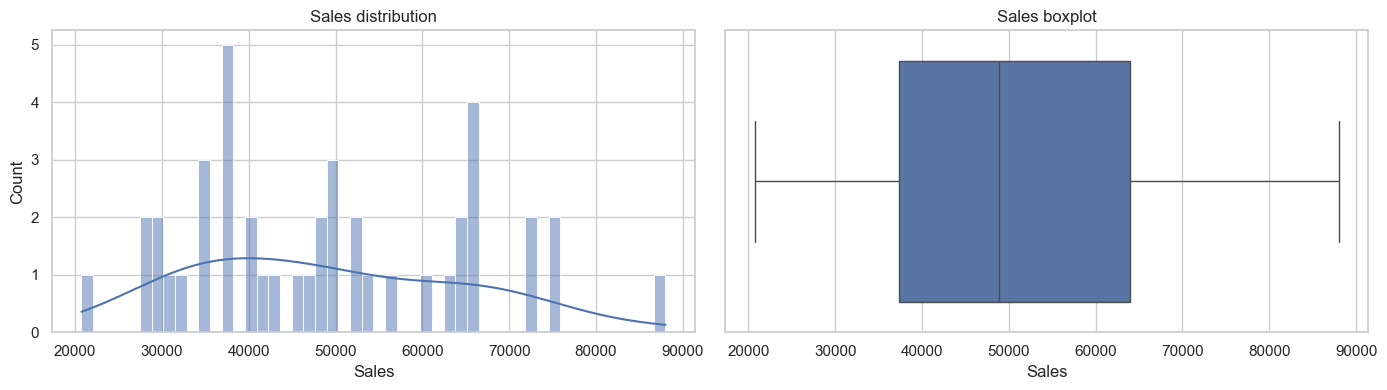

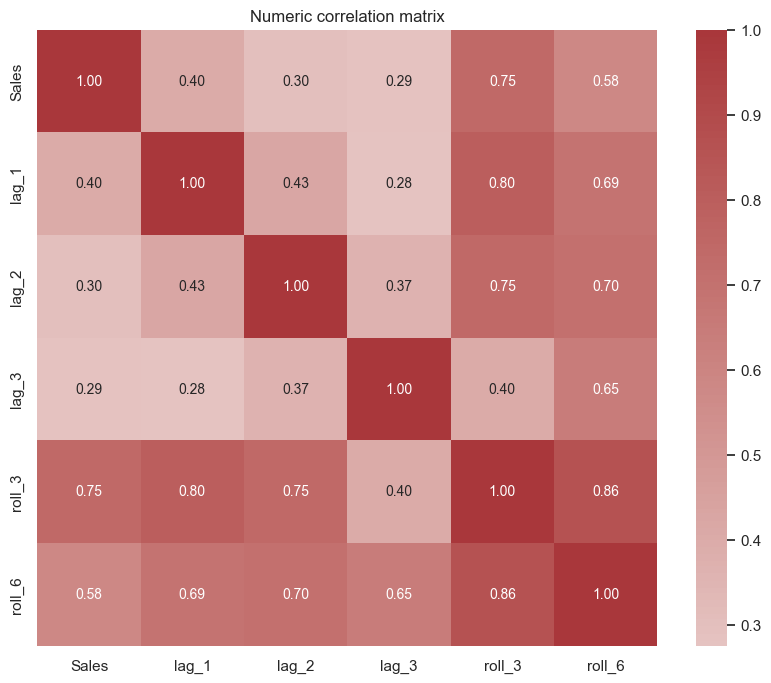


TOP CATEGORIES (per categorical column):


/var/folders/1r/yxjrs_1n717fbfdk8pz9951m0000gn/T/ipykernel_53317/2246285220.py:84: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly = ts[target].resample("M").sum()


ImportError: matplotlib is required for plotting when the default backend "matplotlib" is selected.

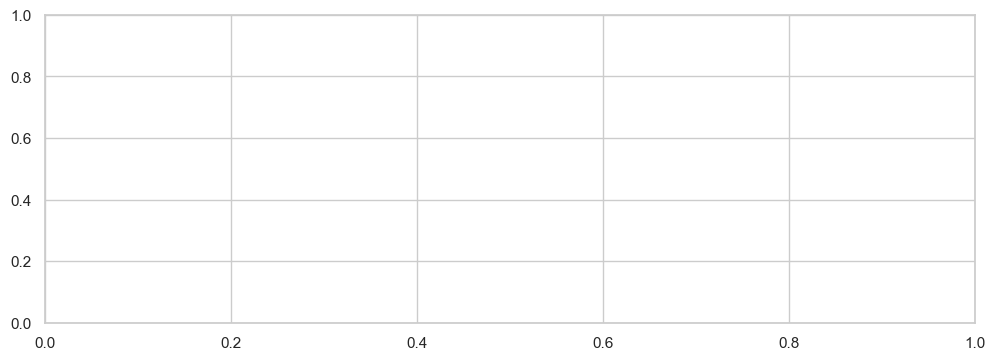

In [161]:
import pandas as pd
import numpy as np
import seaborn as sns
from IPython.display import display

# EDA helper cell (to put at index 0)
# Usage: run this cell (it will use df_cleaned / df / df_ts etc. if available in the notebook)

import matplotlib.pyplot as plt

sns.set(style="whitegrid")
plt.rcParams.update({"figure.figsize": (10, 5), "font.size": 10})

def perform_eda(df=None, date_col='Order Date', target='Sales', cat_cols=None, top_n=10):
    # pick a dataframe if not provided
    if df is None:
        if "df_cleaned" in globals():
            df = globals()["df_cleaned"]
        elif "df" in globals():
            df = globals()["df"]
        else:
            raise ValueError("No dataframe supplied and no df_cleaned/df found in globals.")
    df = df.copy()
    print("DATAFRAME SHAPE:", df.shape)
    print("\nCOLUMNS & TYPES:")
    display(pd.DataFrame(df.dtypes, columns=["dtype"]))
    print("\nFIRST / LAST 3 ROWS:")
    display(pd.concat([df.head(3), df.tail(3)]))
    print("\nBASIC STATS FOR NUMERIC COLUMNS:")
    display(df.select_dtypes(include=np.number).describe().T)

    # missing values
    mv = df.isna().sum().sort_values(ascending=False)
    mv_pct = (mv / len(df) * 100).round(2)
    missing_tbl = pd.concat([mv, mv_pct], axis=1)
    missing_tbl.columns = ["missing_count", "missing_pct"]
    print("\nMISSING VALUES (count, %):")
    display(missing_tbl[missing_tbl.missing_count > 0])

    # convert date_col if present
    if date_col in df.columns:
        try:
            df[date_col] = pd.to_datetime(df[date_col])
        except Exception:
            pass
        print(f"\n{date_col} dtype after conversion: {df[date_col].dtype}")

    # target distribution
    if target in df.columns:
        print(f"\nTARGET ({target}) - basic stats:")
        display(df[target].describe().to_frame().T)
        fig, axes = plt.subplots(1, 2, figsize=(14,4))
        sns.histplot(df[target].dropna(), bins=50, kde=True, ax=axes[0])
        axes[0].set_title(f"{target} distribution")
        sns.boxplot(x=df[target].dropna(), ax=axes[1])
        axes[1].set_title(f"{target} boxplot")
        plt.tight_layout()
        plt.show()

    # numeric correlation heatmap
    num_df = df.select_dtypes(include=np.number)
    if num_df.shape[1] > 1:
        corr = num_df.corr()
        plt.figure(figsize=(10,8))
        sns.heatmap(corr, annot=True, fmt=".2f", cmap="vlag", center=0)
        plt.title("Numeric correlation matrix")
        plt.show()

    # categorical summaries
    if cat_cols is None:
        # pick object columns as categorical
        cat_cols = df.select_dtypes(include=["object", "category"]).columns.tolist()
    print("\nTOP CATEGORIES (per categorical column):")
    for c in cat_cols:
        if c in df.columns:
            print(f"\n{c} (n_unique={df[c].nunique()}):")
            display(df[c].value_counts(dropna=False).head(top_n))

    # time series / trend if date_col and target present
    if (date_col in df.columns) and (target in df.columns):
        ts = df[[date_col, target]].dropna()
        # monthly aggregation
        ts = ts.set_index(date_col).sort_index()
        monthly = ts[target].resample("M").sum()
        fig, ax = plt.subplots(1,1,figsize=(12,4))
        monthly.plot(ax=ax)
        ax.set_title(f"Monthly {target} (sum)")
        ax.set_ylabel(target)
        plt.show()

        # seasonality by month
        monthly_df = monthly.to_frame().assign(month=lambda x: x.index.month)
        plt.figure(figsize=(10,4))
        sns.boxplot(x=monthly_df['month'], y=monthly_df[target])
        plt.title(f"Distribution of monthly {target} by month (1-12)")
        plt.show()

    # groupby aggregates for important categorical columns (if exist)
    group_cols = []
    for cand in ["Category", "Sub-Category", "State", "Region", "City", "Ship Mode", "Segment"]:
        if cand in df.columns:
            group_cols.append(cand)
    for g in group_cols:
        agg = df.groupby(g)[target].agg(['count','sum','mean','median']).sort_values('sum', ascending=False).head(top_n)
        print(f"\nTop {top_n} {g} by total {target}:")
        display(agg)

    # outlier detection simple: flag rows beyond 3*IQR for target
    if target in df.columns:
        q1, q3 = df[target].quantile([0.25,0.75])
        iqr = q3 - q1
        lower, upper = q1 - 3*iqr, q3 + 3*iqr
        outliers = df[(df[target] < lower) | (df[target] > upper)]
        print(f"\nOutliers in {target} beyond 3*IQR: {len(outliers)} rows")
        if len(outliers) > 0:
            display(outliers.head(10))

    print("\nEDA complete.")
    return {
        "missing": missing_tbl,
        "num_corr": num_df.corr() if num_df.shape[1] > 1 else None,
        "monthly_ts": monthly if (date_col in df.columns and target in df.columns) else None
    }

# If there are known helper variables in the notebook, use them:
cat_cols_from_notebook = globals().get("cat_cols", None)
df_to_use = None
if "df_ts" in globals() and isinstance(globals()["df_ts"], pd.DataFrame) and globals()["df_ts"].shape[0] > 0:
    # df_ts already engineered with lags -> use it for numeric EDA if appropriate
    df_to_use = globals()["df_ts"]
elif "df_cleaned" in globals():
    df_to_use = globals()["df_cleaned"]

# Run EDA (this will print and plot inline)
eda_results = perform_eda(df=df_to_use, date_col=globals().get("dt_col", "Order Date"),
                          target=globals().get("tgt_col", "Sales"),
                          cat_cols=cat_cols_from_notebook)